*This Project is the collective work of Anirudh Sagar Gollapalli (EE18B007), Jayadev Joy (EE18B011), Naga Deepthi Chimbili (EE18B043) and Varshitha Vadapally (EE18B065)*

# Toxic Comment Classification

The internet is growing at an exponential rate as one of the largest platforms for human conversations. In order to enforce healthy conversations, restriction
of negative interactions and behavior is necessary. Toxic comments fall under
this category. Hence, there is a need for a solution that can be implemented
on a large scale operation, which is where manual moderation fails. A solution
for this problem is to implement a classification module for the various types of
toxic comments. This can be used for automatic recognition of toxic comments
which is very useful for moderators as well as for users who would want to filter
unwanted contents. With all the progress and improvement in IT and data
science, there is a requirement of a properly designed technique to find and isolate these kinds of comments that we call toxic, which is what motivated us
to undertake this project.

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import string
from keras.preprocessing.text import Tokenizer
from gensim.parsing.preprocessing import strip_short
from nltk.tokenize import word_tokenize
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import TreebankWordTokenizer
from wordcloud import WordCloud
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Input

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Dataset Description

The Data-set used for this task is sourced from a Kaggle competition and is split into training data and test data. It is composed of comments from Wikipedia talk page edits.

The training data-set consists of a total of 159,571 instances with comments and the corresponding multiple binomial labels :

*   toxic
*   severe_toxic
*   obscene
*   threat
*   insult
*   identity_hate

The first 10 comments with their corresponding mutiple binomial label values are shown below :

> 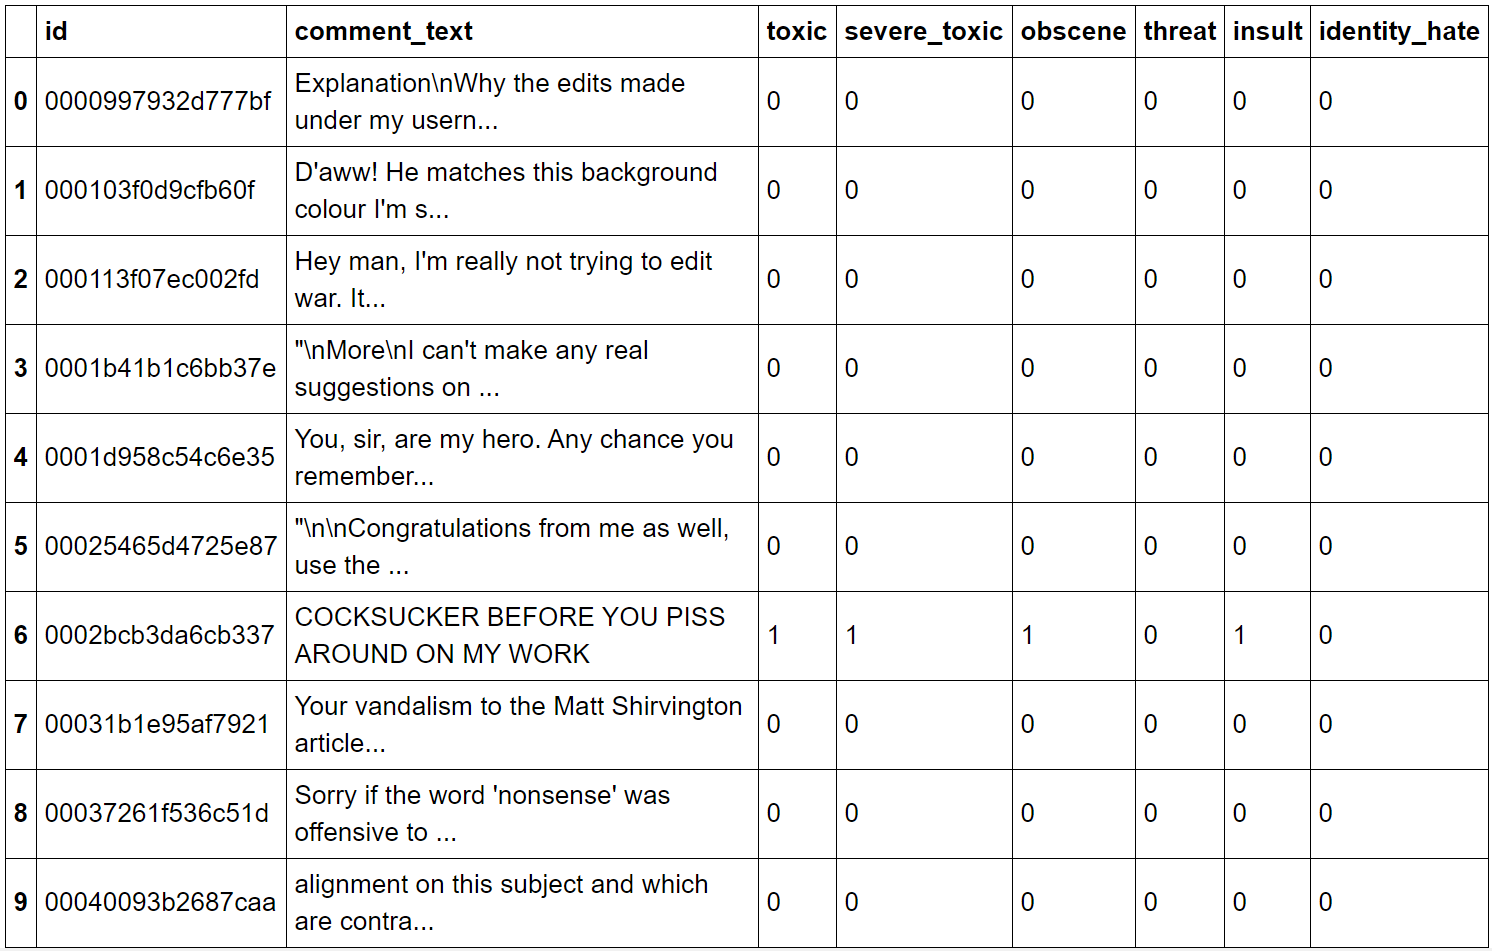

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_data = pd.read_csv("/content/drive/MyDrive/EE5180 Project 2021/Inputs/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/EE5180 Project 2021/Inputs/test.csv")

print("\nThe original training dataset (first 10 entries) is : \n\n",train_data['comment_text'].head(10),"\n")
print("The shape of the training dataset is : ",train_data.shape,"\n")
print("The different column labels of the training dataset are : \n",train_data.columns,"\n\n")

print("\nThe original testing dataset (first 10 entries) is : \n\n",test_data['comment_text'].head(10),"\n")
print("The shape of the testing dataset is : ",test_data.shape,"\n")
print("The different column labels of the testing dataset are : \n",test_data.columns)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

The original training dataset (first 10 entries) is : 

 0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
5    "\n\nCongratulations from me as well, use the ...
6         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7    Your vandalism to the Matt Shirvington article...
8    Sorry if the word 'nonsense' was offensive to ...
9    alignment on this subject and which are contra...
Name: comment_text, dtype: object 

The shape of the training dataset is :  (159571, 8) 

The different column labels of the training dataset are : 
 Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
   

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

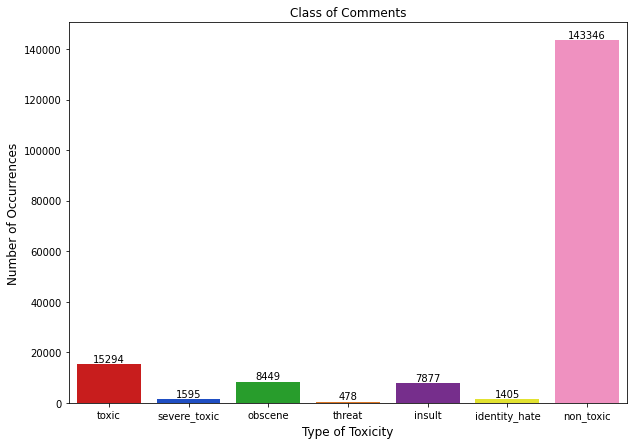

In [ ]:
# Finding all the non-toxic comments and adding a new column to the data, 'non_toxic'
rowsums = train_data.iloc[:,2:].sum(axis=1)
train_data['non_toxic'] = (rowsums == 0)

# Visualizing the number of different types of toxicity of comments

colour = ["red", "blue", "green", "orange", "purple", "yellow", "pink"]
palette = sns.xkcd_palette(colour)
x = train_data.iloc[:,2:].sum()

plt.figure(figsize = (10,7))
plt.title("Class of Comments", fontsize = 12)
plt.xlabel("Type of Toxicity", fontsize = 12)
plt.ylabel("Number of Occurrences", fontsize = 12)
rects = sns.barplot(x.index, x.values, palette=palette).patches
labels = x.values

for rect, label in zip(rects, labels):
  height = rect.get_height()
  sns.barplot(x.index, x.values, palette=palette).text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

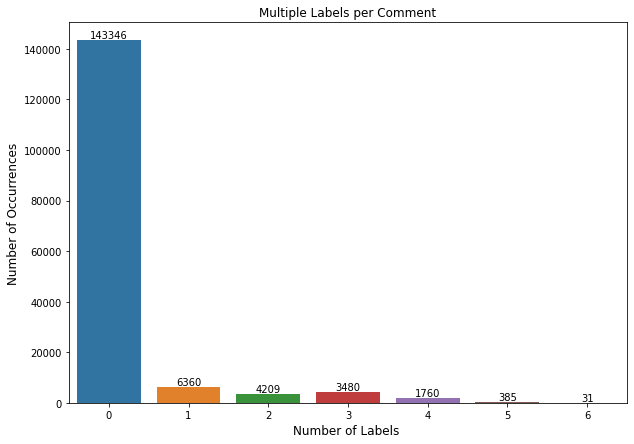

In [ ]:
# Visualizing the number of labels per comment

x = rowsums.value_counts()

plt.figure(figsize = (10,7))
plt.title('Multiple Labels per Comment', fontsize = 12)
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel('Number of Labels ', fontsize = 12)
rects = sns.barplot(x.index, x.values).patches
labels = x.values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    sns.barplot(x.index, x.values).text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')

plt.show()

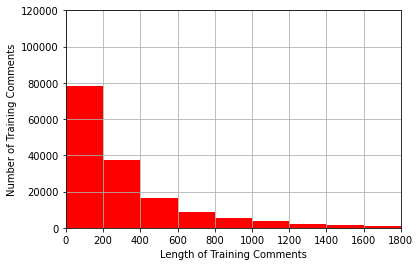

In [ ]:
# Numpy array which stores the length of each comment in the training dataset
x = np.array([len(train_data['comment_text'][i]) for i in range(train_data['comment_text'].shape[0])])

# Visualizing the number of training comments vs the length of training comments
bins = [1,200,400,600,800,1000,1200,1400,1600,1800]
plt.hist(x, bins = bins, color = 'Red')
plt.xlabel('Length of Training Comments')
plt.ylabel('Number of Training Comments')       
plt.axis([0, 1800, 0, 120000])
plt.grid()
plt.show()

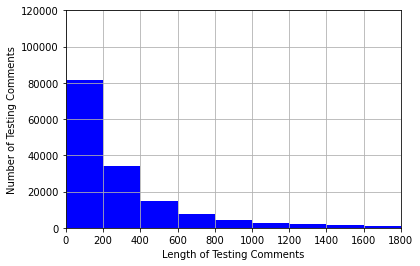

In [ ]:
# Numpy array which stores the length of each comment in the testing dataset
x = np.array([len(test_data['comment_text'][i]) for i in range(test_data['comment_text'].shape[0])])

# Visualizing the number of testing comments vs the length of testing comments
bins = [1,200,400,600,800,1000,1200,1400,1600,1800]
plt.hist(x, bins = bins, color = 'Blue')
plt.xlabel('Length of Testing Comments')
plt.ylabel('Number of Testing Comments')       
plt.axis([0, 1800, 0, 120000])
plt.grid()
plt.show()

## Text Preprocessing



> Since this is a text based dataset, there are a few specific set of preprocessing tasks that we should
do so that we can refine the dataset and help the model perform better.


> First, we would have to remove white spaces, punctuations, etc. Because, they will be of no use to
what the text is implying.

> Then, we should also remove stop words. Because, stopwords such as there, over, etc do not
contribute to the context or meaning of the text.

> After that, we should lemmatize the text. Because, words like changing, changed , changes etc.
more or less mean the same thing, i.e change.

> After performing all the preprocessing tasks, we would obtain a clean optimal dataset. Which we
will then use in the subsequent stages. Such as splitting the dataset into training data and testing
data and then training the model.












In [ ]:
def clean_text(text):
  text = text.lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text

Stopwords = stopwords.words('english')
Lemmatize = nltk.WordNetLemmatizer()

def remove_stopwords(words_list):
  text_list = [word for word in words_list if word not in Stopwords]
  return text_list

def lemmatizer(tokenized_text):
  text = [Lemmatize.lemmatize(word) for word in tokenized_text]
  return text

def preprocess(text):
  preprocessed_file = clean_text(text)
  preprocessed_file = word_tokenize(preprocessed_file)
  preprocessed_file = remove_stopwords(preprocessed_file)
  preprocessed_file = lemmatizer(preprocessed_file)
  preprocessed_file = strip_short(" ".join(preprocessed_file))
  return preprocessed_file

In [ ]:
train_data['comment_text'] = train_data['comment_text'].apply(lambda x: preprocess(x))
test_data['comment_text'] = test_data['comment_text'].apply(lambda x: preprocess(x))

print("\nThe pre-processed training dataset (first 10 entries) is : \n\n",train_data['comment_text'].head(10),"\n\n")
print("The pre-processed testing dataset (first 10 entries) is : \n\n",test_data['comment_text'].head(10))


The pre-processed training dataset (first 10 entries) is : 

 0    explanationwhy edits made username hardcore me...
1    daww match background colour seemingly stuck t...
2    hey man really trying edit war guy constantly ...
3    morei cant make real suggestion improvement wo...
4                  sir hero chance remember page thats
5               congratulation well use tool well talk
6                          cocksucker piss around work
7    vandalism matt shirvington article reverted pl...
8    sorry word nonsense offensive anyway intending...
9                 alignment subject contrary dulithgow
Name: comment_text, dtype: object 


The pre-processed testing dataset (first 10 entries) is : 

 0    bitch rule succesful youll ever whats hating s...
1                                   rfc title fine imo
2                           source zawe ashton lapland
3    look back source information updated correct f...
4                        dont anonymously edit article
5    thank und

In [ ]:
classifier_1_pred = test_data.copy(deep = True)
classifier_2_pred = test_data.copy(deep = True)
classifier_3_pred = test_data.copy(deep = True)
classifier_4_pred = test_data.copy(deep = True)
classifier_5_pred = test_data.copy(deep = True)
classifier_6_pred = test_data.copy(deep = True)

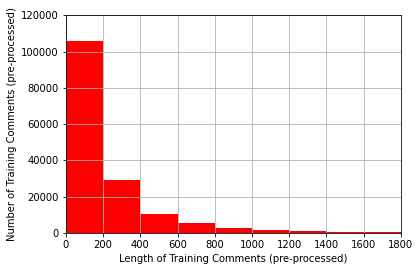

In [ ]:
# Numpy array which stores the length of each comment in the training dataset
x = np.array([len(train_data['comment_text'][i]) for i in range(train_data['comment_text'].shape[0])])

# Visualizing the number of training comments vs the length of training comments
bins = [1,200,400,600,800,1000,1200,1400,1600,1800]
plt.hist(x, bins = bins, color = 'Red')
plt.xlabel('Length of Training Comments (pre-processed)')
plt.ylabel('Number of Training Comments (pre-processed)')       
plt.axis([0, 1800, 0, 120000])
plt.grid()
plt.show()

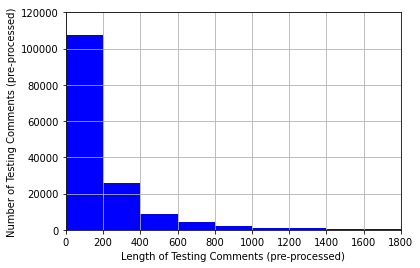

In [ ]:
# Numpy array which stores the length of each comment in the testing dataset
x = np.array([len(test_data['comment_text'][i]) for i in range(test_data['comment_text'].shape[0])])

# Visualizing the number of testing comments vs the length of testing comments
bins = [1,200,400,600,800,1000,1200,1400,1600,1800]
plt.hist(x, bins = bins, color = 'Blue')
plt.xlabel('Length of Testing Comments (pre-processed)')
plt.ylabel('Number of Testing Comments (pre-processed)')       
plt.axis([0, 1800, 0, 120000])
plt.grid()
plt.show()

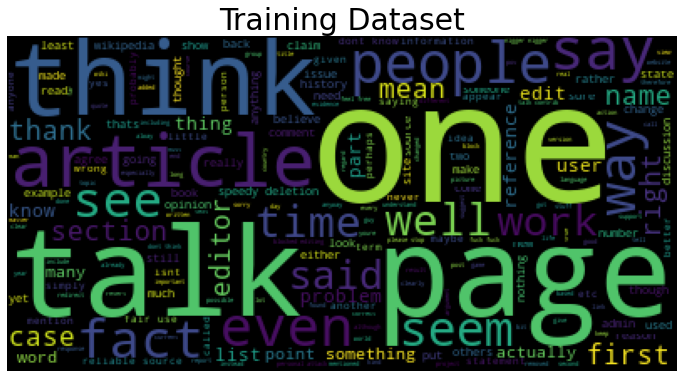

In [ ]:
words = ' '.join([word for word in train_data['comment_text']])
wordcloud = WordCloud().generate(words)

plt.figure(figsize = (12, 19))
plt.imshow(wordcloud)
plt.title('Training Dataset', fontsize = 30)
plt.axis('off')
plt.show()

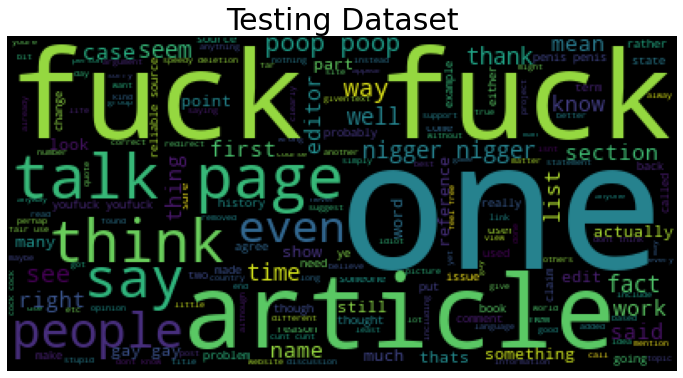

In [ ]:
words = ' '.join([word for word in test_data['comment_text']])
wordcloud = WordCloud().generate(words)

plt.figure(figsize = (12, 19))
plt.imshow(wordcloud)
plt.title('Testing Dataset', fontsize = 30)
plt.axis('off')
plt.show()

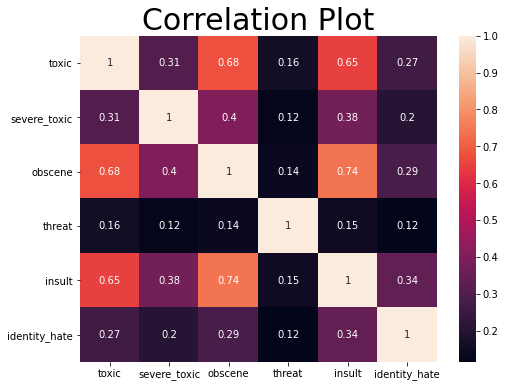

In [ ]:
cp = train_data.iloc[:,2:-1].corr()
plt.figure(figsize = (8,6))
plt.title('Correlation Plot', fontsize = 30)
sns.heatmap(cp, xticklabels = cp.columns.values, yticklabels = cp.columns.values, annot=True)

## Naïve Bayes Classifier

In [ ]:
features = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for i in range(len(features)):
  X_train, X_test, y_train, y_test = train_test_split(train_data['comment_text'], train_data[features[i]], test_size=0.25, random_state = 42)
  Tfidf_vectorizer = TfidfVectorizer(max_features = 5000, stop_words = 'english')
  
  Tfidf_train = Tfidf_vectorizer.fit_transform(X_train) 
  Tfidf_test = Tfidf_vectorizer.transform(X_test)
  Tfidf_test_data = Tfidf_vectorizer.transform(test_data['comment_text'])

  nb_classifier = MultinomialNB()
  nb_classifier.fit(Tfidf_train, y_train)
  y_pred = nb_classifier.predict(Tfidf_test)
  classifier_1_pred[features[i]] = nb_classifier.predict(Tfidf_test_data)

  print("The Final Accuracy on test data for the feature",features[i],"is ", metrics.accuracy_score(y_test, y_pred))
  print ("Confusion Matrix : \n", metrics.confusion_matrix(y_test, y_pred),"\n")

The Final Accuracy on test data for the feature toxic is  0.9493896172260797
Confusion Matrix : 
 [[35921   157]
 [ 1862  1953]] 

The Final Accuracy on test data for the feature severe_toxic is  0.9908003910460482
Confusion Matrix : 
 [[39460    27]
 [  340    66]] 

The Final Accuracy on test data for the feature obscene is  0.9713984909633269
Confusion Matrix : 
 [[37641   109]
 [ 1032  1111]] 

The Final Accuracy on test data for the feature threat is  0.9973679592911037
Confusion Matrix : 
 [[39788     0]
 [  105     0]] 

The Final Accuracy on test data for the feature insult is  0.9665354824154614
Confusion Matrix : 
 [[37690   192]
 [ 1143   868]] 

The Final Accuracy on test data for the feature identity_hate is  0.9913769332965683
Confusion Matrix : 
 [[39529     7]
 [  337    20]] 



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

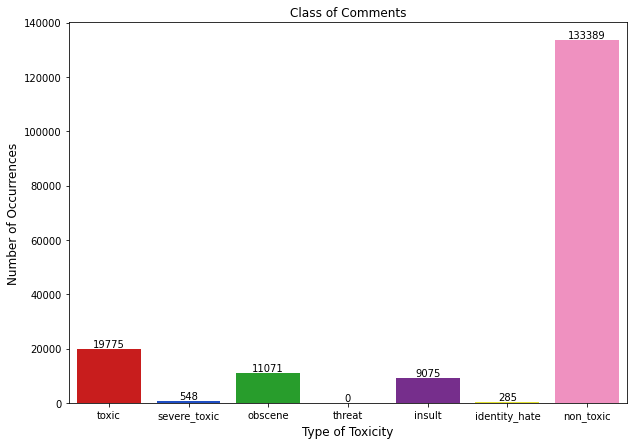

In [ ]:
# Finding all the non-toxic comments and adding a new column to the data, 'non_toxic'
rowsums = classifier_1_pred.iloc[:,2:].sum(axis=1)
classifier_1_pred['non_toxic'] = (rowsums == 0)

# Visualizing the number of different types of toxicity of comments

colour = ["red", "blue", "green", "orange", "purple", "yellow", "pink"]
palette = sns.xkcd_palette(colour)
x = classifier_1_pred.iloc[:,2:].sum()

plt.figure(figsize = (10,7))
plt.title("Class of Comments", fontsize = 12)
plt.xlabel("Type of Toxicity", fontsize = 12)
plt.ylabel("Number of Occurrences", fontsize = 12)
rects = sns.barplot(x.index, x.values, palette=palette).patches
labels = x.values

for rect, label in zip(rects, labels):
  height = rect.get_height()
  sns.barplot(x.index, x.values, palette=palette).text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')

plt.show()

classifier_1_pred.iloc[:20000, :].to_csv("/content/drive/MyDrive/EE5180 Project 2021/Predictions/classifier_1_pred.csv")

## Logistic Regression

In [ ]:
features = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for i in range(len(features)):
  X_train, X_test, y_train, y_test = train_test_split(train_data['comment_text'], train_data[features[i]], test_size = 0.25, random_state = 42)
  Tfidf_vectorizer = TfidfVectorizer(max_features = 5000, stop_words = 'english')
  
  Tfidf_train = Tfidf_vectorizer.fit_transform(X_train) 
  Tfidf_test = Tfidf_vectorizer.transform(X_test)
  Tfidf_test_data = Tfidf_vectorizer.transform(test_data['comment_text'])

  log_reg = LogisticRegression(max_iter = 200)
  log_reg.fit(Tfidf_train, y_train)
  y_pred = log_reg.predict(Tfidf_test)
  classifier_2_pred[features[i]] = log_reg.predict(Tfidf_test_data)

  print("The Final Accuracy on test data for the feature",features[i],"is ", metrics.accuracy_score(y_test, y_pred))
  print ("Confusion Matrix : \n", metrics.confusion_matrix(y_test, y_pred),"\n")

The Final Accuracy on test data for the feature toxic is  0.9557065149274309
Confusion Matrix : 
 [[35803   275]
 [ 1492  2323]] 

The Final Accuracy on test data for the feature severe_toxic is  0.9906249216654551
Confusion Matrix : 
 [[39415    72]
 [  302   104]] 

The Final Accuracy on test data for the feature obscene is  0.9764369688917856
Confusion Matrix : 
 [[37625   125]
 [  815  1328]] 

The Final Accuracy on test data for the feature threat is  0.9975935627804376
Confusion Matrix : 
 [[39781     7]
 [   89    16]] 

The Final Accuracy on test data for the feature insult is  0.9696187301030256
Confusion Matrix : 
 [[37662   220]
 [  992  1019]] 

The Final Accuracy on test data for the feature identity_hate is  0.9920286767101998
Confusion Matrix : 
 [[39512    24]
 [  294    63]] 



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

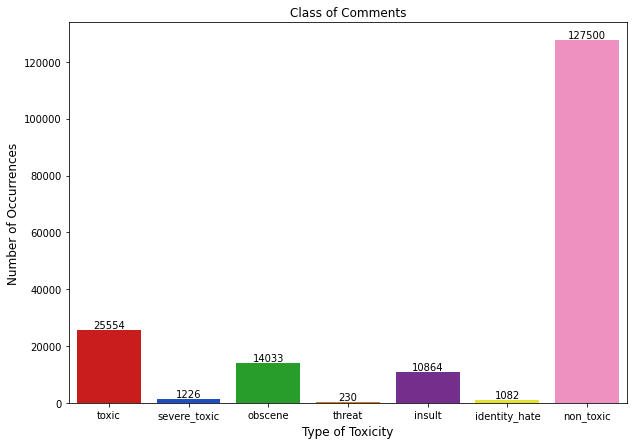

In [ ]:
# Finding all the non-toxic comments and adding a new column to the data, 'non_toxic'
rowsums = classifier_2_pred.iloc[:,2:].sum(axis=1)
classifier_2_pred['non_toxic'] = (rowsums == 0)

# Visualizing the number of different types of toxicity of comments

colour = ["red", "blue", "green", "orange", "purple", "yellow", "pink"]
palette = sns.xkcd_palette(colour)
x = classifier_2_pred.iloc[:,2:].sum()

plt.figure(figsize = (10,7))
plt.title("Class of Comments", fontsize = 12)
plt.xlabel("Type of Toxicity", fontsize = 12)
plt.ylabel("Number of Occurrences", fontsize = 12)
rects = sns.barplot(x.index, x.values, palette=palette).patches
labels = x.values

for rect, label in zip(rects, labels):
  height = rect.get_height()
  sns.barplot(x.index, x.values, palette=palette).text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')

plt.show()

classifier_2_pred.iloc[:20000, :].to_csv("/content/drive/MyDrive/EE5180 Project 2021/Predictions/classifier_2_pred.csv")

## SVM

In [ ]:
features = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for i in range(len(features)):
  X_train, X_test, y_train, y_test = train_test_split(train_data['comment_text'], train_data[features[i]], test_size = 0.25, random_state = 42)
  Tfidf_vectorizer = TfidfVectorizer(max_features = 5000, stop_words = 'english')
  
  Tfidf_train = Tfidf_vectorizer.fit_transform(X_train) 
  Tfidf_test = Tfidf_vectorizer.transform(X_test)
  Tfidf_test_data = Tfidf_vectorizer.transform(test_data['comment_text'])

  SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
  SVM.fit(Tfidf_train, y_train)
  y_pred = SVM.predict(Tfidf_test)
  classifier_3_pred[features[i]] = SVM.predict(Tfidf_test_data)

  print("The Final Accuracy on test data for the feature",features[i],"is ", metrics.accuracy_score(y_test, y_pred))
  print ("Confusion Matrix : \n", metrics.confusion_matrix(y_test, y_pred),"\n")

The Final Accuracy on test data for the feature toxic is  0.9571854711352868
Confusion Matrix : 
 [[35763   315]
 [ 1393  2422]] 

The Final Accuracy on test data for the feature severe_toxic is  0.9898729100343419
Confusion Matrix : 
 [[39485     2]
 [  402     4]] 

The Final Accuracy on test data for the feature obscene is  0.977715388664678
Confusion Matrix : 
 [[37581   169]
 [  720  1423]] 

The Final Accuracy on test data for the feature threat is  0.9975434286716968
Confusion Matrix : 
 [[39786     2]
 [   96     9]] 

The Final Accuracy on test data for the feature insult is  0.9701200711904344
Confusion Matrix : 
 [[37589   293]
 [  899  1112]] 

The Final Accuracy on test data for the feature identity_hate is  0.9918782743839771
Confusion Matrix : 
 [[39526    10]
 [  314    43]] 



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

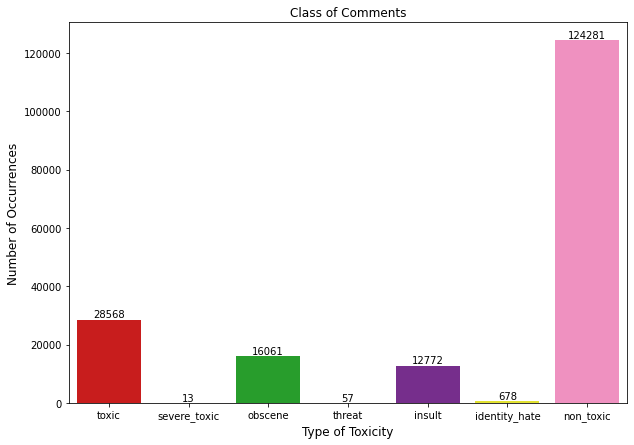

In [ ]:
# Finding all the non-toxic comments and adding a new column to the data, 'non_toxic'
rowsums = classifier_3_pred.iloc[:,2:].sum(axis=1)
classifier_3_pred['non_toxic'] = (rowsums == 0)

# Visualizing the number of different types of toxicity of comments

colour = ["red", "blue", "green", "orange", "purple", "yellow", "pink"]
palette = sns.xkcd_palette(colour)
x = classifier_3_pred.iloc[:,2:].sum()

plt.figure(figsize = (10,7))
plt.title("Class of Comments", fontsize = 12)
plt.xlabel("Type of Toxicity", fontsize = 12)
plt.ylabel("Number of Occurrences", fontsize = 12)
rects = sns.barplot(x.index, x.values, palette=palette).patches
labels = x.values

for rect, label in zip(rects, labels):
  height = rect.get_height()
  sns.barplot(x.index, x.values, palette=palette).text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')

plt.show()

classifier_3_pred.iloc[:20000, :].to_csv("/content/drive/MyDrive/EE5180 Project 2021/Predictions/classifier_3_pred.csv")

## Random Forest

In [ ]:
features = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for i in range(len(features)):
  X_train, X_test, y_train, y_test = train_test_split(train_data['comment_text'], train_data[features[i]], test_size = 0.25, random_state = None)
  Tfidf_vectorizer = TfidfVectorizer(max_features = 5000, stop_words = 'english')
  
  Tfidf_train = Tfidf_vectorizer.fit_transform(X_train) 
  Tfidf_test = Tfidf_vectorizer.transform(X_test)
  Tfidf_test_data = Tfidf_vectorizer.transform(test_data['comment_text'])

  random_forest = RandomForestClassifier()
  random_forest.fit(Tfidf_train, y_train)
  y_pred = random_forest.predict(Tfidf_test)
  classifier_4_pred[features[i]] = random_forest.predict(Tfidf_test_data)

  print("The Final Accuracy on test data for the feature",features[i],"is ", metrics.accuracy_score(y_test, y_pred))
  print ("Confusion Matrix : \n", metrics.confusion_matrix(y_test, y_pred),"\n")

The Final Accuracy on test data for the feature toxic is  0.9527736695660893
Confusion Matrix : 
 [[35535   510]
 [ 1374  2474]] 

The Final Accuracy on test data for the feature severe_toxic is  0.9893966360013035
Confusion Matrix : 
 [[39436    42]
 [  381    34]] 

The Final Accuracy on test data for the feature obscene is  0.9783671320783095
Confusion Matrix : 
 [[37470   296]
 [  567  1560]] 

The Final Accuracy on test data for the feature threat is  0.9968415511493245
Confusion Matrix : 
 [[39757     7]
 [  119    10]] 

The Final Accuracy on test data for the feature insult is  0.9670368235028701
Confusion Matrix : 
 [[37435   418]
 [  897  1143]] 

The Final Accuracy on test data for the feature identity_hate is  0.9922292131451633
Confusion Matrix : 
 [[39529    20]
 [  290    54]] 



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

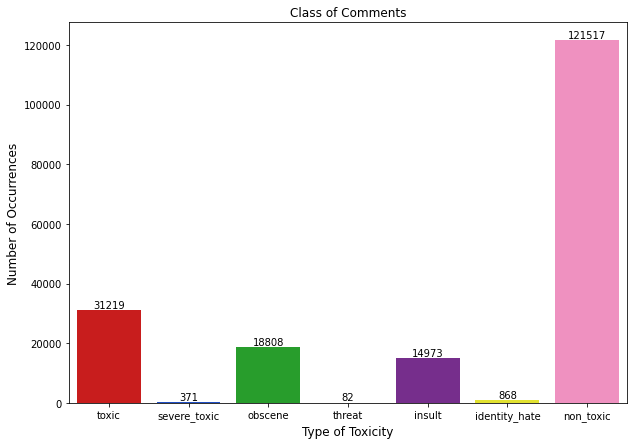

In [ ]:
# Finding all the non-toxic comments and adding a new column to the data, 'non_toxic'
rowsums = classifier_4_pred.iloc[:,2:].sum(axis=1)
classifier_4_pred['non_toxic'] = (rowsums == 0)

# Visualizing the number of different types of toxicity of comments

colour = ["red", "blue", "green", "orange", "purple", "yellow", "pink"]
palette = sns.xkcd_palette(colour)
x = classifier_4_pred.iloc[:,2:].sum()

plt.figure(figsize = (10,7))
plt.title("Class of Comments", fontsize = 12)
plt.xlabel("Type of Toxicity", fontsize = 12)
plt.ylabel("Number of Occurrences", fontsize = 12)
rects = sns.barplot(x.index, x.values, palette=palette).patches
labels = x.values

for rect, label in zip(rects, labels):
  height = rect.get_height()
  sns.barplot(x.index, x.values, palette=palette).text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')

plt.show()

classifier_4_pred.iloc[:20000, :].to_csv("/content/drive/MyDrive/EE5180 Project 2021/Predictions/classifier_4_pred.csv")

## LSTM

In [ ]:
tokenizer = Tokenizer(num_words = 30000)
tokenizer.fit_on_texts(train_data['comment_text'])

traind = tokenizer.texts_to_sequences(train_data['comment_text'])
testd = tokenizer.texts_to_sequences(test_data['comment_text'])

traind = pad_sequences(traind, maxlen=200)
testd = pad_sequences(testd, maxlen=200)

print(traind.shape,train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].shape)

(159571, 200) (159571, 6)


In [ ]:
model = Sequential()
model.add(Embedding(30000, 128))
model.add(LSTM(units = 128, dropout = 0.2, recurrent_dropout = 0.2,return_sequences=True))
model.add(LSTM(units = 128, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(units = 6, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         3840000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 4,103,942
Trainable params: 4,103,942
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC"])
x_train, x_val, y_train, y_val = train_test_split(traind, train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']], shuffle = True, random_state = 123)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
model.fit(x_train, y_train, batch_size = 128, epochs = 1, validation_data = (x_val, y_val))

(119678, 200) (119678, 6) (39893, 200) (39893, 6)
935/935 [==============================] - 2089s 2s/step - loss: 0.1341 - auc: 0.8347 - val_loss: 0.0529 - val_auc: 0.9739
